# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_1s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [9]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2],audio_features.shape[3]), name='Audio_Features')


  features = tf.keras.layers.Conv2D(
              filters=64,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(inputs)

  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1')(features)


  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2')(features)


  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_3',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  features = tf.keras.layers.BatchNormalization()(features)
  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_3')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=512,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.3)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation='softmax')(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_1s_model_training_history_2D_annotated.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [14]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(12565, 128, 87, 4)


In [15]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(3318, 128, 87, 4)


In [16]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 4)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 21, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,715,668 (10.36 MB)

 Trainable params: 2,715,604 (10.36 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.3443 - loss: 13.1875 - weighted_accuracy: 0.3443 - val_accuracy: 0.5570 - val_loss: 9.3429 - val_weighted_accuracy: 0.5570
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6744 - loss: 8.1490 - weighted_accuracy: 0.6744 - val_accuracy: 0.5166 - val_loss: 7.0130 - val_weighted_accuracy: 0.5166
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7924 - loss: 5.8856 - weighted_accuracy: 0.7924 - val_accuracy: 0.5769 - val_loss: 5.7242 - val_weighted_accuracy: 0.5769
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8611 - loss: 4.6164 - weighted_accuracy: 0.8611 - val_accuracy: 0.6190 - val_loss: 4.8254 - val_weighted_accuracy: 0.6190
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8979 - loss: 3.8074 - weighted_accuracy: 0.8979 - val_accuracy: 0.6338 - val_loss: 4.2686 - val_weighted_accuracy: 0.6338
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s

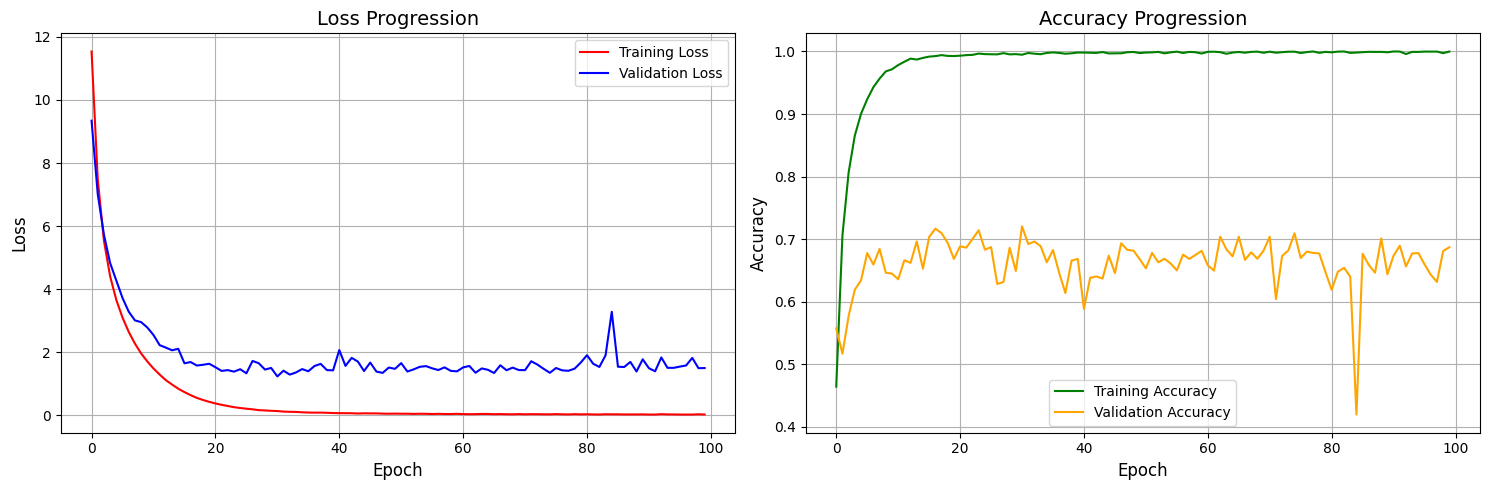

In [17]:
visualize(history, 'all_features')

In [18]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 1.0000 - loss: 0.0174 - weighted_accuracy: 1.0000
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6916 - loss: 1.4510 - weighted_accuracy: 0.6916


In [19]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       455
           1       0.55      0.66      0.60       492
           2       0.78      0.70      0.74       889
           3       0.70      0.85      0.77       150
           4       0.86      0.09      0.16        67
           5       0.61      0.70      0.65        43
           6       0.39      0.67      0.49        24
           7       0.98      1.00      0.99        44
           8       0.40      0.86      0.54        50
           9       0.90      0.97      0.93       169
          10       0.28      0.40      0.33        53
          11       0.50      0.33      0.40        66
          12       0.79      0.71      0.75        59
          13       0.80      0.89      0.84        57
          14       0.66      0.71      0.68        38
          15       0.64      0.43      0.51       311
          16       0.96      0.93      0.94   

### Mel Spectrogram and Chroma

In [20]:
# Train features
target_size = 128
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'],  chroma_tiled), axis=-1)
print(training_features.shape)

(12565, 128, 87, 2)


In [21]:
# Validation Features
target_size = 128
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'],  chroma_tiled), axis=-1)
print(validation_features.shape)

(3318, 128, 87, 2)


In [22]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 2)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 21, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,712,468 (10.35 MB)

 Trainable params: 2,712,404 (10.35 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.4207 - loss: 11.9910 - weighted_accuracy: 0.4207 - val_accuracy: 0.5738 - val_loss: 8.2666 - val_weighted_accuracy: 0.5738
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7575 - loss: 6.5192 - weighted_accuracy: 0.7575 - val_accuracy: 0.6495 - val_loss: 5.0756 - val_weighted_accuracy: 0.6495
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8550 - loss: 4.2237 - weighted_accuracy: 0.8550 - val_accuracy: 0.6712 - val_loss: 3.8849 - val_weighted_accuracy: 0.6712
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8915 - loss: 3.0908 - weighted_accuracy: 0.8915 - val_accuracy: 0.7004 - val_loss: 3.1199 - val_weighted_accuracy: 0.7004
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9166 - loss: 2.4024 - weighted_accuracy: 0.9166 - val_accuracy: 0.6417 - val_loss: 2.8698 - val_weighted_accuracy: 0.6417
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s

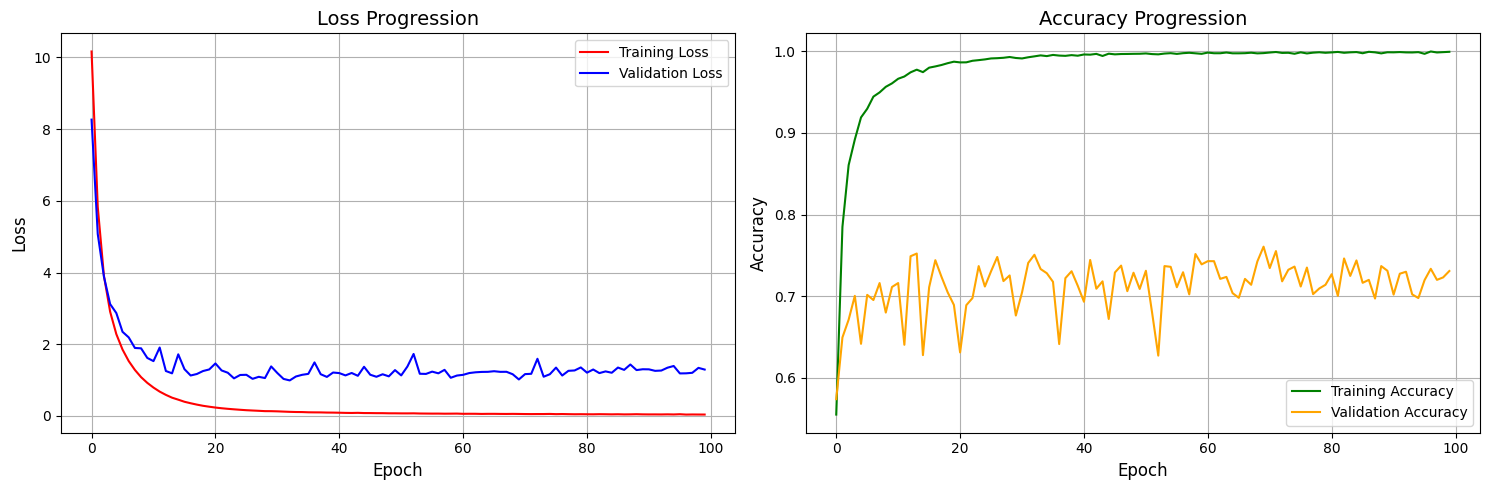

In [23]:
visualize(history, 'melspectrogram_chroma')

In [24]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9930 - loss: 0.0548 - weighted_accuracy: 0.9930
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7330 - loss: 1.2844 - weighted_accuracy: 0.7330


In [25]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       455
           1       0.56      0.60      0.58       492
           2       0.79      0.67      0.73       889
           3       0.78      0.99      0.88       150
           4       0.56      0.07      0.13        67
           5       0.59      0.47      0.52        43
           6       0.67      0.33      0.44        24
           7       1.00      0.98      0.99        44
           8       0.61      0.70      0.65        50
           9       0.85      0.99      0.92       169
          10       0.82      0.58      0.68        53
          11       0.68      0.23      0.34        66
          12       0.75      0.68      0.71        59
          13       0.81      0.67      0.73        57
          14       0.55      0.74      0.63        38
          15       0.55      0.94      0.69       311
          16       0.96      0.85      0.90   

### With Mel Spectrogram, MFCCs and Chroma

In [26]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(12565, 128, 87, 3)


In [27]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(3318, 128, 87, 3)


In [28]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 21, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,714,068 (10.35 MB)

 Trainable params: 2,714,004 (10.35 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.4187 - loss: 12.5765 - weighted_accuracy: 0.4187 - val_accuracy: 0.6410 - val_loss: 9.4631 - val_weighted_accuracy: 0.6410
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7612 - loss: 7.9061 - weighted_accuracy: 0.7612 - val_accuracy: 0.6875 - val_loss: 6.4707 - val_weighted_accuracy: 0.6875
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8346 - loss: 5.6827 - weighted_accuracy: 0.8346 - val_accuracy: 0.6588 - val_loss: 5.1311 - val_weighted_accuracy: 0.6588
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8800 - loss: 4.3145 - weighted_accuracy: 0.8800 - val_accuracy: 0.6724 - val_loss: 4.2093 - val_weighted_accuracy: 0.6724
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9119 - loss: 3.4012 - weighted_accuracy: 0.9119 - val_accuracy: 0.7206 - val_loss: 3.4816 - val_weighted_accuracy: 0.7206
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 7s

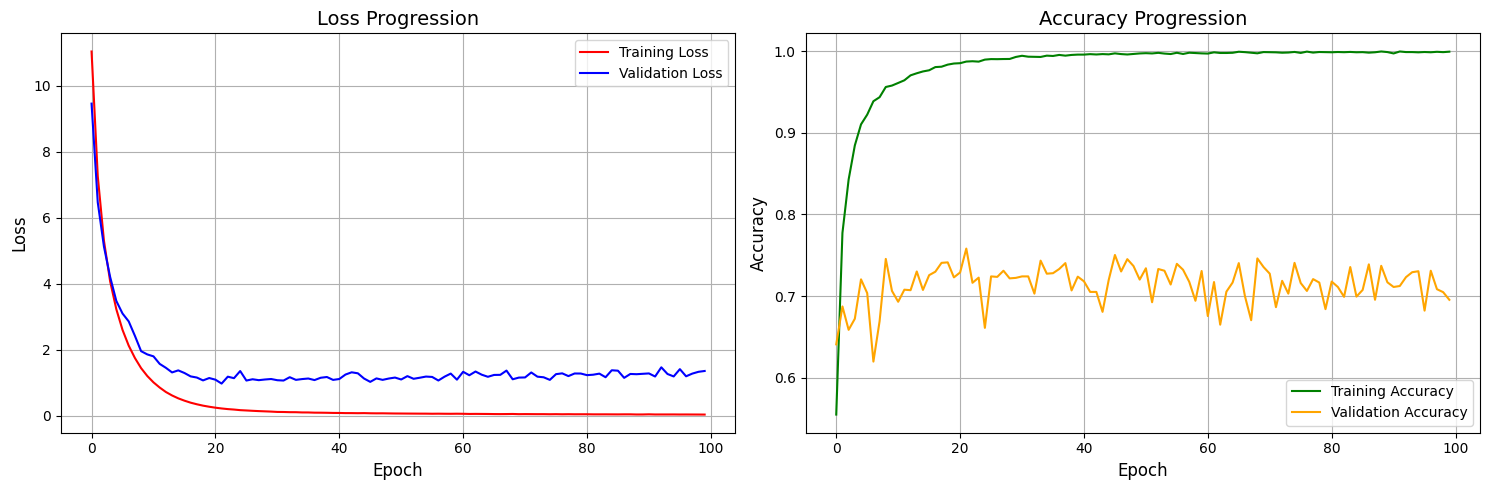

In [29]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [30]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9994 - loss: 0.0381 - weighted_accuracy: 0.9994
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6970 - loss: 1.3211 - weighted_accuracy: 0.6970


In [31]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       455
           1       0.45      0.63      0.52       492
           2       0.75      0.60      0.67       889
           3       0.91      0.99      0.95       150
           4       0.75      0.13      0.23        67
           5       0.76      0.37      0.50        43
           6       0.24      0.62      0.34        24
           7       1.00      0.98      0.99        44
           8       0.58      0.60      0.59        50
           9       0.98      0.95      0.96       169
          10       0.55      0.89      0.68        53
          11       0.59      0.58      0.58        66
          12       0.56      0.53      0.54        59
          13       0.65      0.68      0.67        57
          14       0.25      0.76      0.38        38
          15       0.78      0.50      0.61       311
          16       0.89      0.98      0.93   

### With Mel Spectrogram and MFCCs

In [32]:
# Train features
training_features = np.expand_dims(train_features['melspectrogram'], axis=-1)
print(training_features.shape)

(12565, 128, 87, 1)


In [33]:
# Validation Features
validation_features = np.expand_dims(val_features['melspectrogram'], axis=-1)
print(validation_features.shape)

(3318, 128, 87, 1)


In [34]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 21, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,710,868 (10.34 MB)

 Trainable params: 2,710,804 (10.34 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.4157 - loss: 11.6204 - weighted_accuracy: 0.4157 - val_accuracy: 0.5720 - val_loss: 7.7227 - val_weighted_accuracy: 0.5720
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7715 - loss: 5.9510 - weighted_accuracy: 0.7715 - val_accuracy: 0.6320 - val_loss: 4.5492 - val_weighted_accuracy: 0.6320
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8576 - loss: 3.6135 - weighted_accuracy: 0.8576 - val_accuracy: 0.6832 - val_loss: 3.2097 - val_weighted_accuracy: 0.6832
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8988 - loss: 2.4714 - weighted_accuracy: 0.8988 - val_accuracy: 0.6796 - val_loss: 2.5771 - val_weighted_accuracy: 0.6796
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9245 - loss: 1.8430 - weighted_accuracy: 0.9245 - val_accuracy: 0.7022 - val_loss: 2.2210 - val_weighted_accuracy: 0.7022
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s

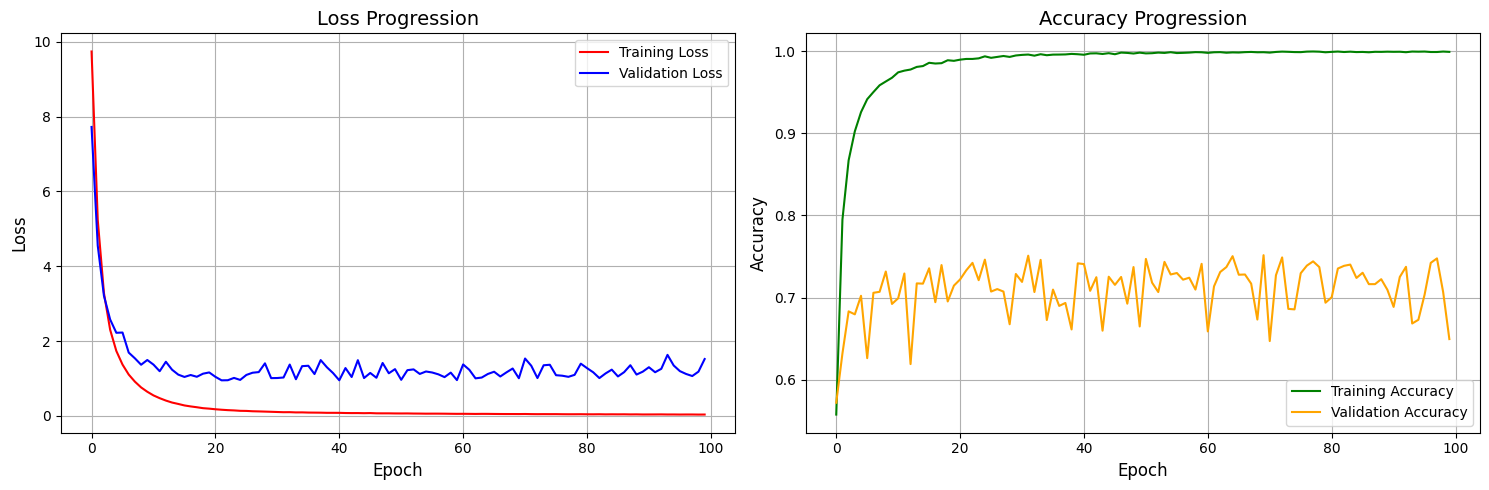

In [35]:
visualize(history, 'mfcc_melspectrogram')

In [36]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9831 - loss: 0.0793 - weighted_accuracy: 0.9831
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6636 - loss: 1.4719 - weighted_accuracy: 0.6636


In [37]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       455
           1       0.45      0.62      0.52       492
           2       0.84      0.61      0.70       889
           3       0.86      0.99      0.92       150
           4       0.75      0.04      0.08        67
           5       0.50      0.05      0.09        43
           6       0.25      0.58      0.35        24
           7       0.93      0.95      0.94        44
           8       0.90      0.38      0.54        50
           9       0.94      0.92      0.93       169
          10       0.59      0.77      0.67        53
          11       0.26      0.12      0.16        66
          12       0.29      0.75      0.42        59
          13       0.58      0.89      0.70        57
          14       0.27      0.71      0.39        38
          15       0.77      0.31      0.44       311
          16       0.88      0.67      0.76   

### With Mel Spectrogram

In [38]:
# Train features
target_size = 128

training_features = np.expand_dims(train_features['melspectrogram'], axis=-1)
print(training_features.shape)

(12565, 128, 87, 1)


In [39]:
# Validation Features
target_size = 128
validation_features = np.expand_dims(val_features['melspectrogram'], axis=-1)
print(validation_features.shape)

(3318, 128, 87, 1)


In [40]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 87, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 87, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 43, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 21, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5120)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,710,868 (10.34 MB)

 Trainable params: 2,710,804 (10.34 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.4494 - loss: 11.6193 - weighted_accuracy: 0.4494 - val_accuracy: 0.6468 - val_loss: 7.9465 - val_weighted_accuracy: 0.6468
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8059 - loss: 6.1797 - weighted_accuracy: 0.8059 - val_accuracy: 0.6709 - val_loss: 4.8436 - val_weighted_accuracy: 0.6709
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8698 - loss: 3.9711 - weighted_accuracy: 0.8698 - val_accuracy: 0.6947 - val_loss: 3.5544 - val_weighted_accuracy: 0.6947
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9134 - loss: 2.8147 - weighted_accuracy: 0.9134 - val_accuracy: 0.7001 - val_loss: 2.8573 - val_weighted_accuracy: 0.7001
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9303 - loss: 2.1406 - weighted_accuracy: 0.9303 - val_accuracy: 0.7257 - val_loss: 2.3613 - val_weighted_accuracy: 0.7257
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 6s

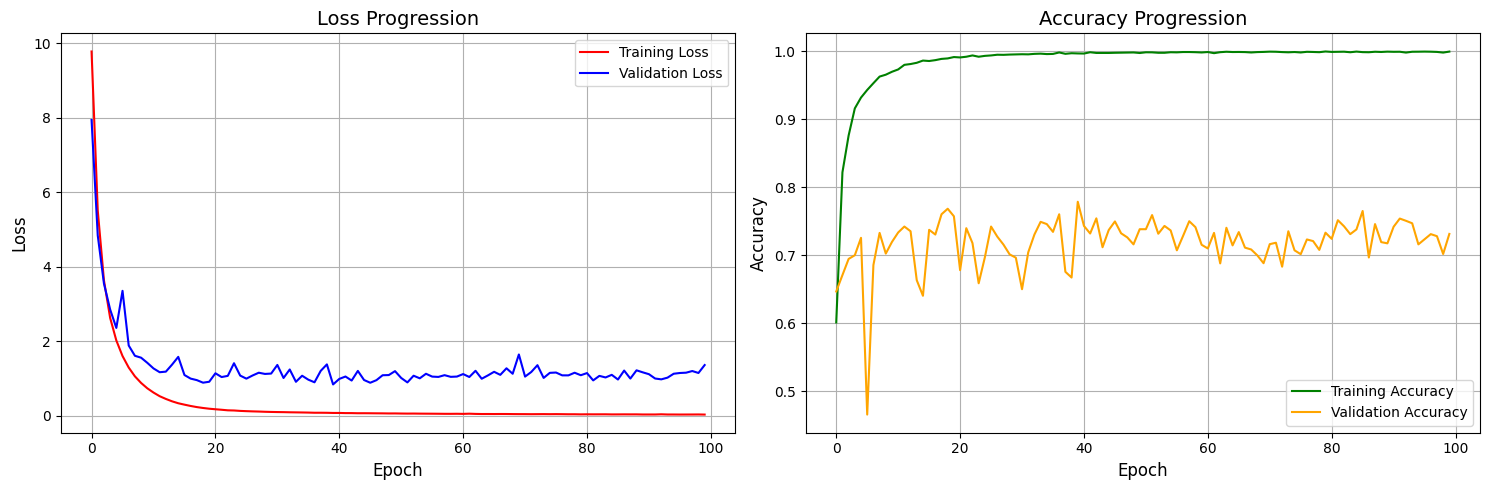

In [41]:
visualize(history, 'melspectrogram')

In [42]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9945 - loss: 0.0504 - weighted_accuracy: 0.9945
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7344 - loss: 1.3245 - weighted_accuracy: 0.7344


In [43]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       455
           1       0.64      0.47      0.54       492
           2       0.80      0.77      0.79       889
           3       0.75      1.00      0.85       150
           4       0.80      0.06      0.11        67
           5       0.64      0.16      0.26        43
           6       0.42      0.46      0.44        24
           7       0.86      1.00      0.93        44
           8       0.83      0.58      0.68        50
           9       0.93      0.97      0.95       169
          10       0.73      0.87      0.79        53
          11       0.55      0.17      0.26        66
          12       0.45      0.80      0.58        59
          13       0.62      0.91      0.74        57
          14       0.49      0.74      0.59        38
          15       0.67      0.76      0.71       311
          16       0.91      0.96      0.94   

## Review all the results

In [44]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,1.000,0.687
4,melspectrogram,0.995,0.731
1,melspectrogram_chroma,0.993,0.731
2,melspectrogram_chroma_mfcc,0.999,0.696
3,mfcc_melspectrogram,0.983,0.649


In [45]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.682      0.946
4              melspectrogram     0.716      0.954
1       melspectrogram_chroma     0.724      0.957
2  melspectrogram_chroma_mfcc     0.699      0.949
3         mfcc_melspectrogram     0.644      0.951
